# Prediction of the Mars Express Thermal Power Consumption
Exercise inspired by the [**Mars Express Power Challenge**](https://kelvins.esa.int/mars-express-power-challenge/)

**Prepared for the [AI Hightlight topic](https://indico.cern.ch/event/777129/page/16087-ai-highlight-topic) at the [6th EIROforum School on Instrumentation (ESI 2019)](https://indico.cern.ch/event/777129/)**

**Author: [Jose Martinez Heras](https://www.linkedin.com/in/josemartinezheras/)**


**Exercise description**
The [Mars Express Orbiter (MEX)](http://www.esa.int/Our_Activities/Space_Science/Mars_Express/) provides science data from Mars about its ionosphere and ground subsurface composition. The 3D imagery of Mars has provided the community with unprecedented information about the planet. Today, thanks to the work of careful and expert operators, Mars Express Orbiter still provides information that supports ground exploration missions on Mars (Curiosity, Opportunity, ...) and a lot of other research.

The Mars Express Orbiter is operated by the [European Space Agency](http://www.esa.int) from its operations centre (Darmstadt, Germany) where all the telemetry is analysed. The health status of the spacecraft is carefully monitored to plan future science observations and to avoid power shortages.

Operators of Mars Express keep track of the thermal power consumption thanks to the telemetry data. The spacecraft uses electric power coming from the solar arrays (or batteries, during eclipses) not only to supply power to the platform units, but also to the thermal subsystem, which keeps the entire spacecraft within its operating temperature range. The remaining available power can be used by the payloads to do science operations:

```
Science Power = Produced Power - Platform Power - Thermal Power
``` 

The Mars Express Power Challenge focuses on the difficult problem of predicting the thermal power consumption. Three full Martian years of Mars Express telemetry are made available and you are challenged to predict the thermal subsystem power consumption on the following Martian year. If successful, the winning method will be a new tool helping the Mars Express Orbiter deliver science data for a longer period of time.

**Differences compared to the original challenge**
These changes will allow to run the machine learning process faster (due to fewer data and less resolution) and will provide better results as the data that needs to be predicted is similar to the data used for training. This simplification is needed to fit the discussion about this problem in our 45 minutes session.The original harder problem was tackled during a period of 3 months.
*  instead of trying to predict all 33 heater lines, we will be predicting the sum of them, that is, the Total Thermal Power Consumption
*  instead of providing the original sampling rate of the thermal power consumption, we will be using resampled hourly means
*  since Mars Express had change in the way it was operated in March 2013, we will use data only prior to March 2013

**Connection to the Theoretical session**: we will be puting in practice all that we've learnt during the theoretical session:
*  Introduction to Machine Learning include key concepts such as
    *  Machine Learning workflow (problem understanding, evaluation criteria, baseline, data preparation, machine learning, error analysis, etc.)
    *  Generalization
*  Decision Trees, Ensembles, Random Forests and Surrogate Models

## Import Libraries

In [13]:
# import libraries
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

import pydot
from sklearn.externals.six import StringIO  
from IPython.display import Image

## Define some function we will be using across the exercise
*  find out the feature importances of a model
*  tree visualization

In [14]:
def get_importances(model, features, decimals=3):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(min(10, len(indices))):
        feature = features[indices[f]]
        importance = importances[indices[f]]
        if importance < 0.001:
            break
        print(str(round(importance, decimals)) + " " + feature)
        
def visualize_tree(tree, features):       
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=features, filled=True, proportion = True)
    graph, = pydot.graph_from_dot_data(dot_data.getvalue())  

    return Image(graph.create(prog=['dot', '-Gdpi=300'], format='png'))

## Read data

In [15]:
dmop = pd.read_csv('data/dmop.zip', parse_dates=[0], infer_datetime_format=True).set_index('datetime')
evtf = pd.read_csv('data/evtf.zip', parse_dates=[0], infer_datetime_format=True).set_index('datetime')
ftl = pd.read_csv('data/ftl.zip', parse_dates=[0,1], infer_datetime_format=True).set_index('datetime')
ltdata = pd.read_csv('data/ltdata.zip', parse_dates=[0], infer_datetime_format=True).set_index('datetime').ffill()
power = pd.read_csv('data/hourly_total_power.zip', parse_dates=[0], infer_datetime_format=True, header=None, names=['datetime', 'current']).set_index('datetime').ffill()
saaf = pd.read_csv('data/saaf.zip', parse_dates=[0], infer_datetime_format=True).set_index('datetime').ffill()

## Getting familiar with the data
Let's have a look to the data

### DMOP: Detailed Mission Operations Plan
The DMOP files show when the different subsystems' commands have been triggered. Each subsystem command string include the subsystem name along with the command name. Each subsystem command name can be considered as a signature. Due to the amount of different commands, they won't be explained here. These commands have different effects on temperatures of the different subsystems of the spacecraft thus impacting in different ways the thermal subsystem's reactions. In these commands you may find the ON/OFF of radio communications, the ON/OFF of the science instruments, etc.

In [16]:
dmop.head()

,subsystem
datetime,
2008-08-22 00:00:11,AXXX301A
2008-08-22 00:28:29,AAAAF20C1
2008-08-22 00:28:34,AAAAF57A1
2008-08-22 00:28:39,AAAAF23G1
2008-08-22 00:28:44,AAAAF60A1


In [17]:
unique_dmop = dmop['subsystem'].unique()
len(unique_dmop)

21974

### EVTF: Event Files
This file contains a lot of events. It covers parts of the flight dynamics timeline present in the FTL and complements information with a lot of other events. In this file you can find the following eclipse events: _PENUMBRA_START, _PENUMBRA_END, _UMBRA_START, _UMBRA_END which indicates the start and end time of different phases of the eclipse (penumbra/umbra).

Some of the descriptions are self explanatory while others are not. Due to the amount of different events, they won't be explained here. Nevertheless, the descriptions can be used as signatures of events, similar to the subsystem commands in the DMOP files.

In [18]:
evtf.head()

,description
datetime,
2008-08-22 00:17:33,MLG_LOS_05_/_RTLT_02373
2008-08-22 00:19:16,NNO_AOS_00_/_RTLT_02373
2008-08-22 00:30:58,MLG_LOS_02_/_RTLT_02373
2008-08-22 00:42:35,NNO_AOS_05_/_RTLT_02373
2008-08-22 01:05:59,NNO_AOS_10_/_RTLT_02374


In [19]:
unique_evtf = evtf['description'].unique()
len(unique_evtf)

75561

### FTL: Flight Dynamics Time Line
List of spacecraft pointint events. The events listed here are pointing and action commands that can impact the attitude of the satellite, thus they also may impact the solar aspect angles of the orbiter and/or the switch ON/OFF of some instrumentation.

In [20]:
ftl.head()

,type,flagcomms
datetime,,
2008-08-22 00:00:13,EARTH,False
2008-08-22 00:38:14,EARTH,True
2008-08-22 01:45:55,EARTH,False
2008-08-22 01:46:59,SLEW,False
2008-08-22 01:57:33,NADIR,False


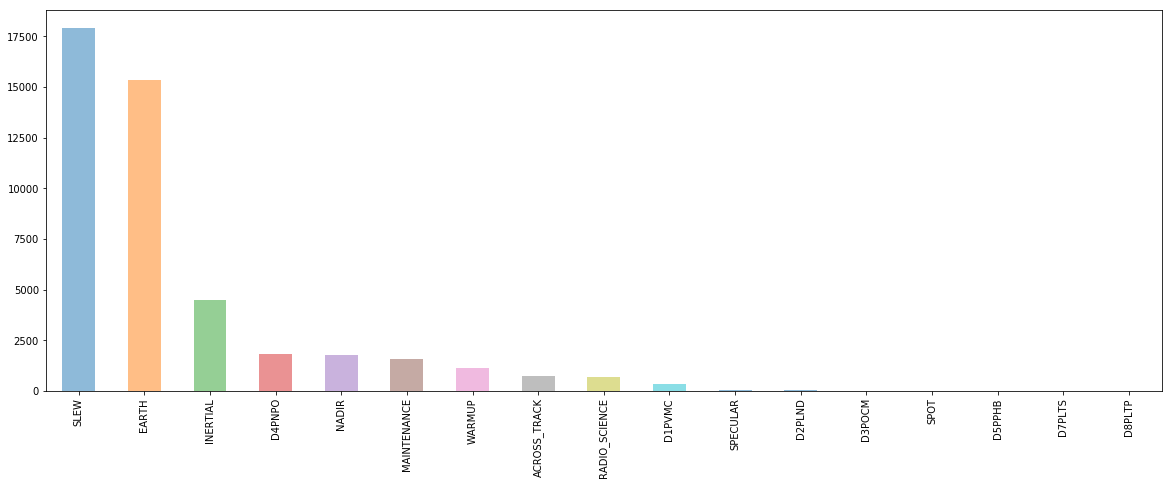

In [21]:
ftl['type'].value_counts().plot.bar(figsize=(20,7), alpha=0.5)

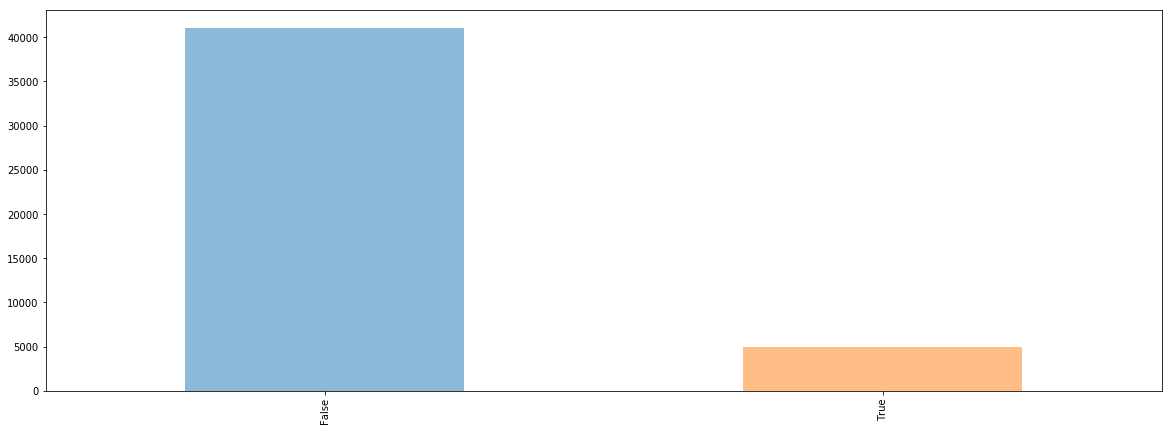

In [22]:
ftl['flagcomms'].value_counts().plot.bar(figsize=(20,7), alpha=0.5)

### LTDATA: long term data including sun-mars distance and solar constant on Mars
*  sunmars_km: the distance in kilometers between the Sun and Mars
*  earthmars_km: the distance in kilometers between the Earth and Mars
*  sunmarsearthangle_deg: Sun-Mars-Earth angle in degrees
*  solarconstantmars: solar constant at Mars in W/m2
*  eclipseduration_min: total durations of all eclipses in the day, in minutes
*  occultationduration_min: total durations of all occultations in the day, in minutes

In [23]:
ltdata.head()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
datetime,,,,,,
2008-08-22,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-23,2.418002e+08,3.563037e+08,19.390075,522.863537,1.783333,26.933333
2008-08-24,2.416603e+08,3.568432e+08,19.214734,523.468926,0.000000,26.583333
2008-08-25,2.415193e+08,3.573744e+08,19.039052,524.080161,0.000000,26.100000
2008-08-26,2.413773e+08,3.578973e+08,18.863029,524.697233,0.000000,25.750000


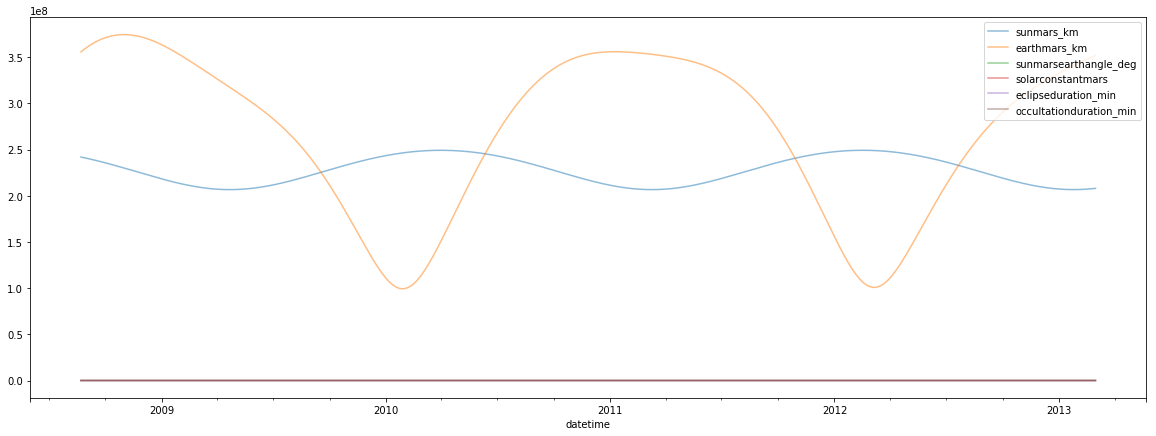

In [24]:
ltdata.plot(figsize=(20,7), alpha=0.5);

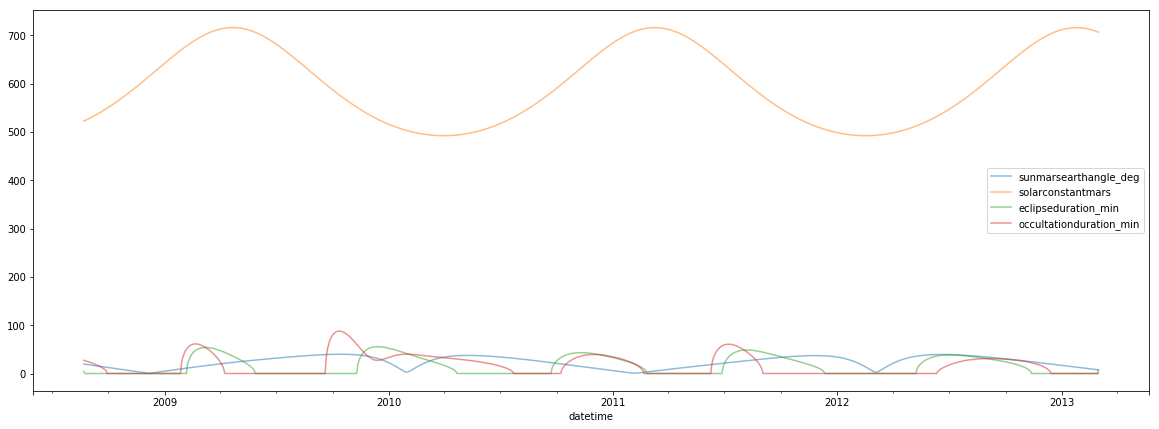

In [25]:
ltdata[['sunmarsearthangle_deg', 'solarconstantmars', 'eclipseduration_min', 'occultationduration_min']].plot(figsize=(20,7), alpha=0.5)

### SAAF: Solar aspect angles are expressed with respect to the Sun-MarsExpress line
*  sa: solar aspect angle, angle of Mars Express solar panels' normal
*  sx: solar angle of the X axis of satellite
*  sy: solar angle of the Y axis of satellite
*  sz: solar angle of the Z axis of satellite

The angles are a good information about how much power from the solar panels the spacecraft is going to get (sa) and how much each of its faces is roasting to the sun or freezing in its own shadow (sx, sy, sz).

In [26]:
saaf.head()

,sa,sx,sy,sz
datetime,,,,
2008-08-22 00:00:13,0.32,14.55,90.32,104.55
2008-08-22 00:00:35,0.34,14.56,90.34,104.55
2008-08-22 00:01:35,0.34,14.56,90.34,104.55
2008-08-22 00:02:35,0.34,14.56,90.34,104.55
2008-08-22 00:03:35,0.34,14.56,90.34,104.55


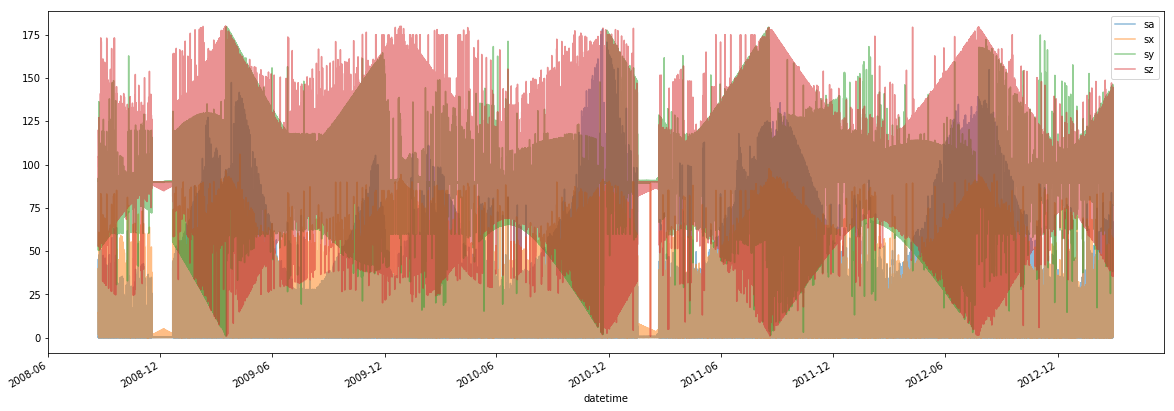

In [27]:
saaf.plot(figsize=(20,7), alpha=0.5);

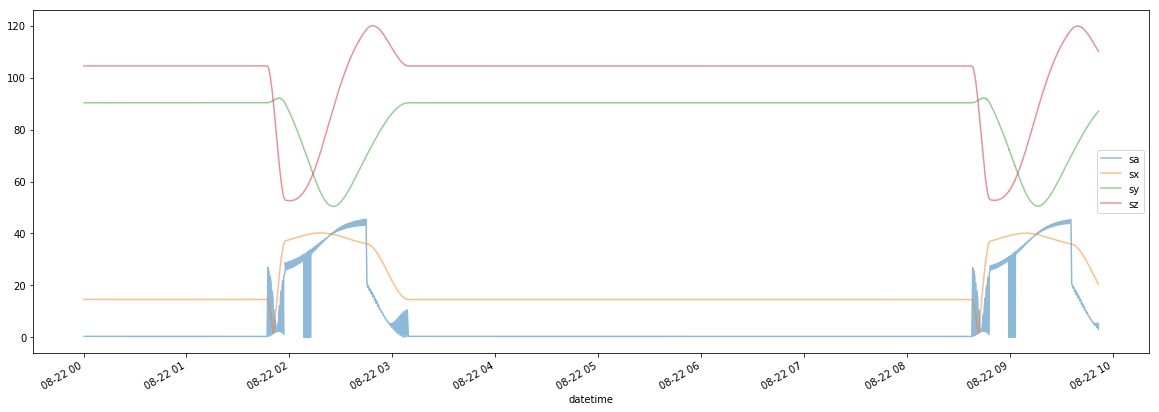

In [28]:
saaf.iloc[:1000].plot(figsize=(20,7), alpha=0.5);

### Power: sum of the electrical current of all 33 power lines averaged by hour

In [29]:
power.head()

,current
datetime,
2008-08-22 00:00:00,5.015263
2008-08-22 01:00:00,5.446681
2008-08-22 02:00:00,6.130791
2008-08-22 03:00:00,4.666763
2008-08-22 04:00:00,4.647753


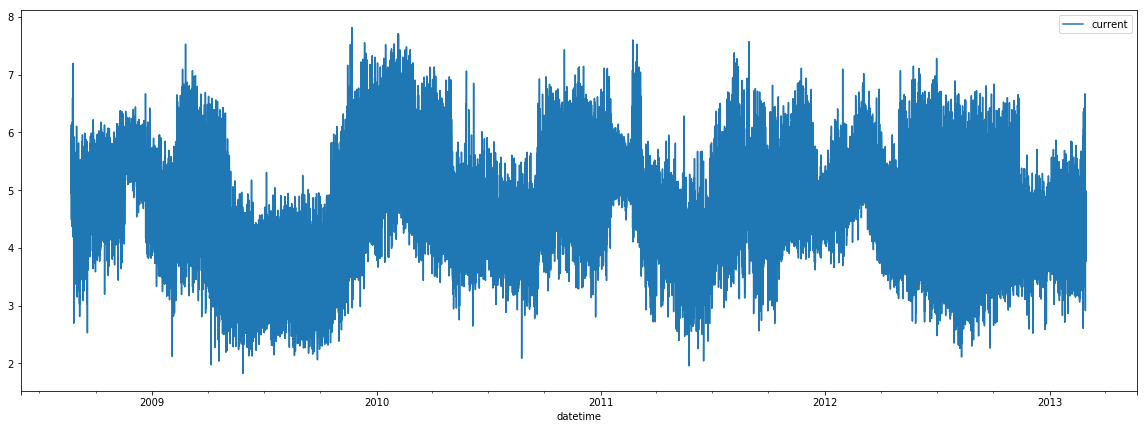

In [30]:
power.plot(figsize=(20,7));

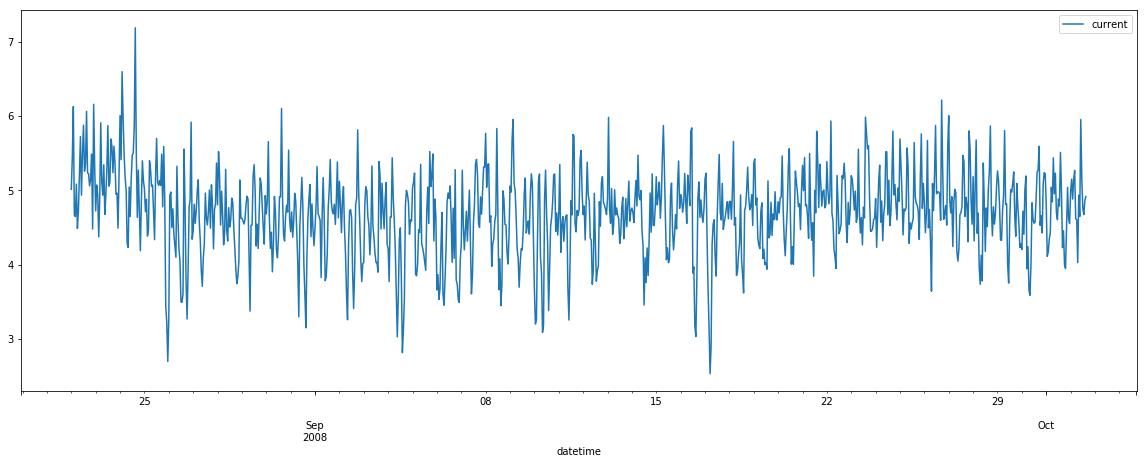

In [31]:
power.iloc[:1000].plot(figsize=(20,7));

## Evaluation
Let's divide our data in 2 different sets:
*  train: to train the model
*  validation: to check how good the model is generalizing



In [32]:
print('First datetime: ' + str(power.index[0]))
print('Last datetime: ' + str(power.index[-1]))

First datetime: 2008-08-22 00:00:00
Last datetime: 2013-03-01 00:00:00


Let's use the last year to validate ... 

In [33]:
split_date = pd.to_datetime('2012-03-01')
power_train = power[power.index < split_date]
power_test = power[power.index >= split_date]

In [34]:
power_test.head()

,current
datetime,
2012-03-01 00:00:00,5.333069
2012-03-01 01:00:00,5.546034
2012-03-01 02:00:00,5.185242
2012-03-01 03:00:00,5.617313
2012-03-01 04:00:00,5.528652


## Mean Baseline
As a simple baseline, let's predict as future current, the training set current mean

In [35]:
mean_baseline = power_train.mean()

mse_mean_baseline_train = mean_squared_error(y_true=power_train, y_pred=[mean_baseline] * len(power_train))
print('MSE train, mean baseline: ' + str(mse_mean_baseline_train))

mse_mean_baseline_test = mean_squared_error(y_true=power_test, y_pred=[mean_baseline] * len(power_test))
print('MSE test, mean baseline: ' + str(mse_mean_baseline_test))


MSE train, mean baseline: 0.7772779780281017
MSE test, mean baseline: 0.6549476448740532


## Let's do some Machine Learning

Let's start with the **long term** data. The distance to the Sun should be quite relevant, right?

In [36]:
ltdata.head()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
datetime,,,,,,
2008-08-22,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-23,2.418002e+08,3.563037e+08,19.390075,522.863537,1.783333,26.933333
2008-08-24,2.416603e+08,3.568432e+08,19.214734,523.468926,0.000000,26.583333
2008-08-25,2.415193e+08,3.573744e+08,19.039052,524.080161,0.000000,26.100000
2008-08-26,2.413773e+08,3.578973e+08,18.863029,524.697233,0.000000,25.750000


### We need to have the same time resolution, so that we can combine LTDATA and Power data
We will up-sample the data with linear interpolation

In [37]:
resampled_ltdata = ltdata.resample('1h').mean().interpolate(method='linear')
resampled_ltdata.head()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
datetime,,,,,,
2008-08-22 00:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-22 01:00:00,2.419331e+08,3.557789e+08,19.557784,522.288980,4.067361,27.380556
2008-08-22 02:00:00,2.419273e+08,3.558017e+08,19.550492,522.313961,3.968056,27.361111
2008-08-22 03:00:00,2.419216e+08,3.558245e+08,19.543201,522.338941,3.868750,27.341667
2008-08-22 04:00:00,2.419158e+08,3.558473e+08,19.535909,522.363922,3.769444,27.322222


In [38]:
ltdata_train = resampled_ltdata[resampled_ltdata.index < split_date]
ltdata_test = resampled_ltdata[resampled_ltdata.index >= split_date]

### Let's train a Decision Tree

In [39]:
ltdata_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
ltdata_tree.fit(ltdata_train, power_train)

pred_ltdata_tree_train = ltdata_tree.predict(ltdata_train)
mse_ltdata_tree_train = mean_squared_error(y_true=power_train, y_pred=pred_ltdata_tree_train)
print('MSE train, with a tree using LTDATA: ' + str(mse_ltdata_tree_train))

pred_ltdata_tree_test = ltdata_tree.predict(ltdata_test)
mse_ltdata_tree_test = mean_squared_error(y_true=power_test, y_pred=pred_ltdata_tree_test)
print('MSE test, with a tree using LTDATA: ' + str(mse_ltdata_tree_test))

MSE train, with a tree using LTDATA: 0.4806314640290177
MSE test, with a tree using LTDATA: 0.6507421486135995


It is a bit better than the baseline ... but not much

In [40]:
visualize_tree(ltdata_tree, ltdata.columns)

### Let's have a look to the SAAF

#### Since we will need to do it several times, let's create functions that we can reuse


In [41]:
def split_train_test(df, split_date=pd.to_datetime('2012-03-01')):
    train = df[df.index < split_date]
    test  = df[df.index >= split_date]
    return train, test

def evaluate_model(model, X_train, X_test, trained=False):
    if not trained:
        model.fit(X_train, power_train.values.ravel())

    pred_model_train = model.predict(X_train)
    min_length_train = min(len(power_train), len(pred_model_train))
    mse_model_train = mean_squared_error(y_true=power_train[:min_length_train], y_pred=pred_model_train[:min_length_train])
    print('MSE train: ' + str(mse_model_train))

    pred_model_test = model.predict(X_test)
    min_length_test = min(len(power_test), len(pred_model_test))
    mse_model_test = mean_squared_error(y_true=power_test[:min_length_test], y_pred=pred_model_test[:min_length_test])
    print('MSE test: ' + str(mse_model_test))

def evaluate_rf(X_train, X_test, max_depth=20, n_estimators=100, min_samples_leaf=0.005):
    model = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, n_jobs=-1, random_state=42)
    evaluate_model(model, X_train, X_test)
    return model


def evaluate_tree(X_train, X_test, max_depth=3, min_samples_leaf=0.01):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    evaluate_model(model, X_train, X_test)
    return model



In [42]:
resampled_saaf = saaf.resample('1h').mean().interpolate(method='linear')
resampled_saaf.head()


,sa,sx,sy,sz
datetime,,,,
2008-08-22 00:00:00,0.339355,14.551129,90.339355,104.548871
2008-08-22 01:00:00,6.619310,18.012184,90.500460,90.396437
2008-08-22 02:00:00,30.927137,37.511806,64.618150,86.910793
2008-08-22 03:00:00,1.534306,15.217917,89.967083,105.197917
2008-08-22 04:00:00,0.339672,14.523934,90.339672,104.520492


In [43]:
saaf_train, saaf_test = split_train_test(resampled_saaf)
saaf_rf = evaluate_rf(saaf_train, saaf_test);

MSE train: 0.45650386027601747
MSE test: 0.6510271861157227


### Could we combine LTDATA and SAAF?
Sure, let's do it

In [44]:
ltdata_and_SAAF = pd.concat((resampled_ltdata, resampled_saaf), axis=1).ffill()
ltdata_and_SAAF.head()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min,sa,sx,sy,sz
datetime,,,,,,,,,,
2008-08-22 00:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000,0.339355,14.551129,90.339355,104.548871
2008-08-22 01:00:00,2.419331e+08,3.557789e+08,19.557784,522.288980,4.067361,27.380556,6.619310,18.012184,90.500460,90.396437
2008-08-22 02:00:00,2.419273e+08,3.558017e+08,19.550492,522.313961,3.968056,27.361111,30.927137,37.511806,64.618150,86.910793
2008-08-22 03:00:00,2.419216e+08,3.558245e+08,19.543201,522.338941,3.868750,27.341667,1.534306,15.217917,89.967083,105.197917
2008-08-22 04:00:00,2.419158e+08,3.558473e+08,19.535909,522.363922,3.769444,27.322222,0.339672,14.523934,90.339672,104.520492


In [45]:
ltdata_and_SAAF_train, ltdata_and_SAAF_test = split_train_test(ltdata_and_SAAF)
ltdata_and_SAAF_rf = evaluate_rf(ltdata_and_SAAF_train, ltdata_and_SAAF_test )

MSE train: 0.28917868498623484
MSE test: 0.5112220361440526


### Let's have a look to the FTL (Flight Dynamics Time Line) data

In [46]:
ftl.head()

,type,flagcomms
datetime,,
2008-08-22 00:00:13,EARTH,False
2008-08-22 00:38:14,EARTH,True
2008-08-22 01:45:55,EARTH,False
2008-08-22 01:46:59,SLEW,False
2008-08-22 01:57:33,NADIR,False


We need to transform it so that Machine Learning can make something useful with it

First of all, let's transform flagcomms to numeric


In [47]:
ftl2 = ftl.copy()
ftl2['flagcomms'] = ftl['flagcomms'].astype(int)
ftl2.head()

,type,flagcomms
datetime,,
2008-08-22 00:00:13,EARTH,0
2008-08-22 00:38:14,EARTH,1
2008-08-22 01:45:55,EARTH,0
2008-08-22 01:46:59,SLEW,0
2008-08-22 01:57:33,NADIR,0


Let's encode 'type' by using one-hot-encoding

In [48]:
ftl2 = pd.get_dummies(ftl['type'])
ftl2.head()

,ACROSS_TRACK,D1PVMC,D2PLND,D3POCM,D4PNPO,D5PPHB,D7PLTS,D8PLTP,EARTH,INERTIAL,MAINTENANCE,NADIR,RADIO_SCIENCE,SLEW,SPECULAR,SPOT,WARMUP
datetime,,,,,,,,,,,,,,,,,
2008-08-22 00:00:13,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2008-08-22 00:38:14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2008-08-22 01:45:55,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2008-08-22 01:46:59,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2008-08-22 01:57:33,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


We need the data resampled every hour

In [49]:
resampled_ftl = ftl2.resample('1h').mean().ffill()
resampled_ftl.head()

,ACROSS_TRACK,D1PVMC,D2PLND,D3POCM,D4PNPO,D5PPHB,D7PLTS,D8PLTP,EARTH,INERTIAL,MAINTENANCE,NADIR,RADIO_SCIENCE,SLEW,SPECULAR,SPOT,WARMUP
datetime,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2008-08-22 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0
2008-08-22 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0
2008-08-22 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2008-08-22 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [50]:
ftl_train, ftl_test = split_train_test(resampled_ftl)
ftl_rf = evaluate_rf(ftl_train, ftl_test)

MSE train: 0.6903267153997253
MSE test: 0.5873124704747359


### Lets combine everything so far

In [51]:
combined = pd.concat((ltdata_and_SAAF, resampled_ftl), axis=1).ffill()
combined.head()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min,sa,sx,sy,sz,...,D8PLTP,EARTH,INERTIAL,MAINTENANCE,NADIR,RADIO_SCIENCE,SLEW,SPECULAR,SPOT,WARMUP
datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000,0.339355,14.551129,90.339355,104.548871,...,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2008-08-22 01:00:00,2.419331e+08,3.557789e+08,19.557784,522.288980,4.067361,27.380556,6.619310,18.012184,90.500460,90.396437,...,0.0,0.333333,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0
2008-08-22 02:00:00,2.419273e+08,3.558017e+08,19.550492,522.313961,3.968056,27.361111,30.927137,37.511806,64.618150,86.910793,...,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0
2008-08-22 03:00:00,2.419216e+08,3.558245e+08,19.543201,522.338941,3.868750,27.341667,1.534306,15.217917,89.967083,105.197917,...,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2008-08-22 04:00:00,2.419158e+08,3.558473e+08,19.535909,522.363922,3.769444,27.322222,0.339672,14.523934,90.339672,104.520492,...,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [52]:
combined_train, combined_test = split_train_test(combined)
combined_rf = evaluate_rf(combined_train, combined_test)

MSE train: 0.2847129117810916
MSE test: 0.4802905905623439


#### Let's get a graphical intuition
This is our prediction on trainining data

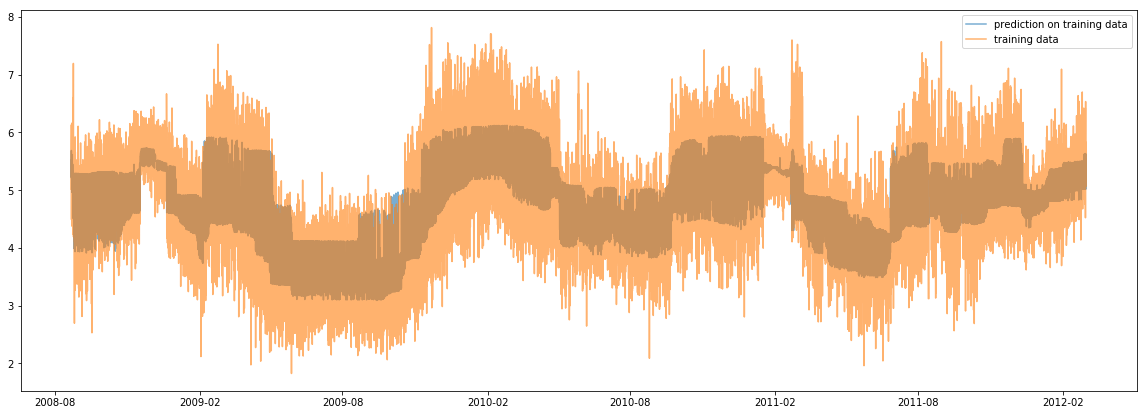

In [53]:
combined_pred_train = pd.DataFrame(combined_rf.predict(combined_train), index=power_train.index, columns=power_train.columns)
plt.figure(figsize=(20,7))
plt.plot(combined_pred_train, alpha=0.6, label='prediction on training data')
plt.plot(power_train, alpha=0.6, label='training data')
plt.legend();
plt.show();

This is how it looks like on **testing** data

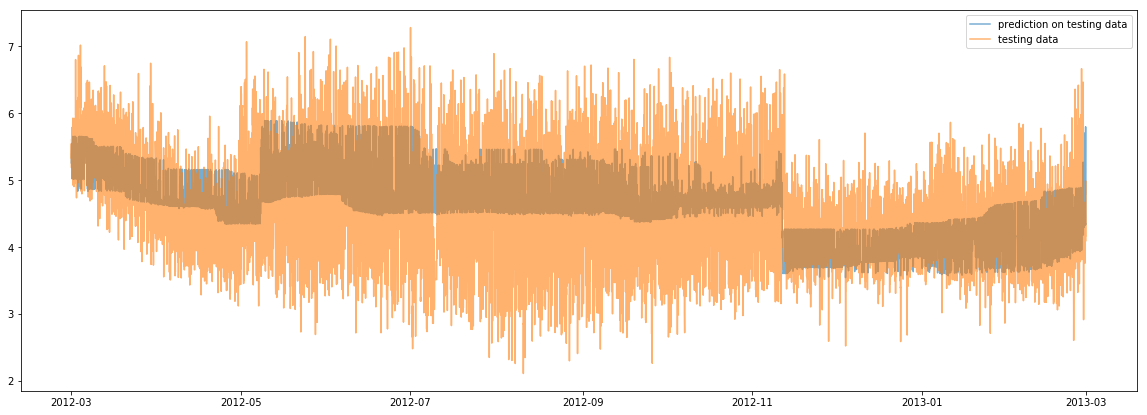

In [54]:
combined_pred_test = pd.DataFrame(combined_rf.predict(combined_test), index=power_test.index, columns=power_test.columns)
plt.figure(figsize=(20,7))
plt.plot(combined_pred_test, alpha=0.6, label='prediction on testing data')
plt.plot(power_test, alpha=0.6, label='testing data')
plt.legend();
plt.show();

#### Let's find what is more important so far ...

In [55]:
get_importances(combined_rf, combined_train.columns)

0.314 sz
0.202 eclipseduration_min
0.125 solarconstantmars
0.125 sunmars_km
0.096 earthmars_km
0.074 sunmarsearthangle_deg
0.023 sa
0.015 EARTH
0.009 occultationduration_min
0.008 sy


It looks like eclipses are important ... let find more about eclipses
### Let's look at EVTF for eclipses

In [56]:
evtf.head()

,description
datetime,
2008-08-22 00:17:33,MLG_LOS_05_/_RTLT_02373
2008-08-22 00:19:16,NNO_AOS_00_/_RTLT_02373
2008-08-22 00:30:58,MLG_LOS_02_/_RTLT_02373
2008-08-22 00:42:35,NNO_AOS_05_/_RTLT_02373
2008-08-22 01:05:59,NNO_AOS_10_/_RTLT_02374


In [57]:
# This function has been taken from Alex Buer's solution: https://github.com/alex-bauer/kelvin-power-challenge/blob/master/src/features/features_evtf_states.py
def state_vector(start_ev, end_ev, fieldname):
    u = evtf[evtf['description'].isin([start_ev, end_ev])].copy()
    u[u['description'] == start_ev] = 1
    u[u['description'] == end_ev] = 0
    u['description'] = u['description'].astype(int)
    u = u.resample('60s').max().resample('1H').mean().fillna(0)
    u = u.rename(columns={'description': fieldname})
    u = u.replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
    return u

In [58]:
umbra = state_vector('MAR_UMBRA_START', 'MAR_UMBRA_END', 'evtf_umbra')
penumbra = state_vector('MAR_PENUMBRA_START', 'MAR_PENUMBRA_END', 'evtf_penumbra')

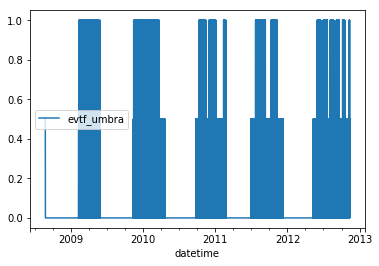

In [59]:
umbra.plot();

In [60]:
eclipses = pd.concat((umbra, penumbra), axis=1).fillna(0)
eclipses.head()

,evtf_umbra,evtf_penumbra
datetime,,
2008-08-22 02:00:00,0.5,0.5
2008-08-22 03:00:00,0.0,0.0
2008-08-22 04:00:00,0.0,0.0
2008-08-22 05:00:00,0.0,0.0
2008-08-22 06:00:00,0.0,0.0


Let's add the eclipseses to the combined data

In [61]:
combined = pd.concat((combined, eclipses), axis=1).fillna(0)
combined_train, combined_test = split_train_test(combined)
combined_rf = evaluate_rf(combined_train, combined_test)

MSE train: 0.284694456424894
MSE test: 0.4791872684339473


In [62]:
get_importances(combined_rf, combined_train.columns)

0.314 sz
0.201 eclipseduration_min
0.126 solarconstantmars
0.124 sunmars_km
0.096 earthmars_km
0.074 sunmarsearthangle_deg
0.023 sa
0.015 EARTH
0.009 occultationduration_min
0.008 sy


It looks like the 'eclipseduration_min' contains enough information about eclipses

### Still we have DMOP pending ... let's work on that

In [63]:
dmop.head(10)

,subsystem
datetime,
2008-08-22 00:00:11,AXXX301A
2008-08-22 00:28:29,AAAAF20C1
2008-08-22 00:28:34,AAAAF57A1
2008-08-22 00:28:39,AAAAF23G1
2008-08-22 00:28:44,AAAAF60A1
2008-08-22 00:40:15,AXXX305A
2008-08-22 00:47:15,AXXX380A
2008-08-22 00:57:15,ASEQ4200
2008-08-22 01:09:41,ATTTF301E


This correspond to commands to the spacecraft. The commands tells the spacecraft what to do ... but we don't have much information on what it is doing just from the acronym

Let's try to count how many of these commands happen per hour per group. Let's assume that a group is recognized by its first 4 letters

In [64]:
dmop2 = dmop['subsystem'].str[0:4]
dmop2.head()

datetime
2008-08-22 00:00:11    AXXX
2008-08-22 00:28:29    AAAA
2008-08-22 00:28:34    AAAA
2008-08-22 00:28:39    AAAA
2008-08-22 00:28:44    AAAA
Name: subsystem, dtype: object

In [65]:
dmop2 = pd.get_dummies(dmop2)
dmop2.head()

,AAAA,AACF,ADMC,AHHH,AMMM,AOOO,APSF,APWF,ASEQ,ASSS,...,PENE,PENS,PPNE,PPNS,SCMN,Trig,UDBE,UDBS,UPBE,UPBS
datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 00:28:29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 00:28:34,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 00:28:39,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 00:28:44,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
dmop2 = dmop2.resample('1h').sum()
dmop2.head()

,AAAA,AACF,ADMC,AHHH,AMMM,AOOO,APSF,APWF,ASEQ,ASSS,...,PENE,PENS,PPNE,PPNS,SCMN,Trig,UDBE,UDBS,UPBE,UPBS
datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 01:00:00,0,0,0,0,11,0,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 02:00:00,0,0,0,0,2,0,5,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2008-08-22 03:00:00,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2008-08-22 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Let's also combine DMOP2

In [67]:
combined = pd.concat((combined, dmop2), axis=1).fillna(0)

In [68]:
combined_train, combined_test = split_train_test(combined)
combined_rf = evaluate_rf(combined_train, combined_test)

MSE train: 0.27240662711645774
MSE test: 0.44573861092408


In [69]:
get_importances(combined_rf, combined_train.columns)

0.3 sz
0.193 eclipseduration_min
0.126 sunmars_km
0.122 solarconstantmars
0.083 earthmars_km
0.071 sunmarsearthangle_deg
0.024 MPER
0.022 PENE
0.011 occultationduration_min
0.009 sa


In [70]:
def make_plots(model, train, test):
    pred_train = pd.DataFrame(model.predict(train), index=power_train.index, columns=power_train.columns)
    plt.figure(figsize=(20,7))
    plt.plot(pred_train, alpha=0.6, label='prediction on training data')
    plt.plot(power_train, alpha=0.6, label='training data')
    plt.legend();
    plt.show();

    pred_test = pd.DataFrame(model.predict(test), index=power_test.index, columns=power_test.columns)
    plt.figure(figsize=(20,7))
    plt.plot(pred_test, alpha=0.6, label='prediction on testing data')
    plt.plot(power_test, alpha=0.6, label='testing data')
    plt.legend();
    plt.show();

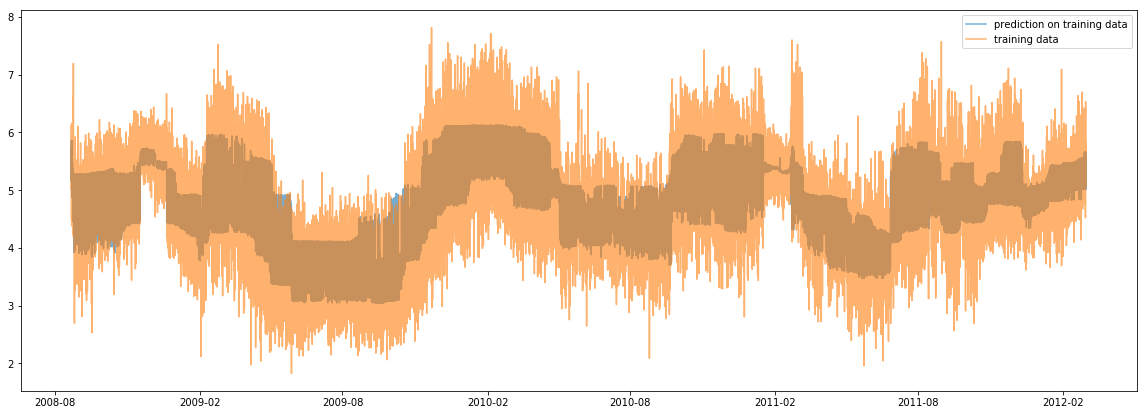

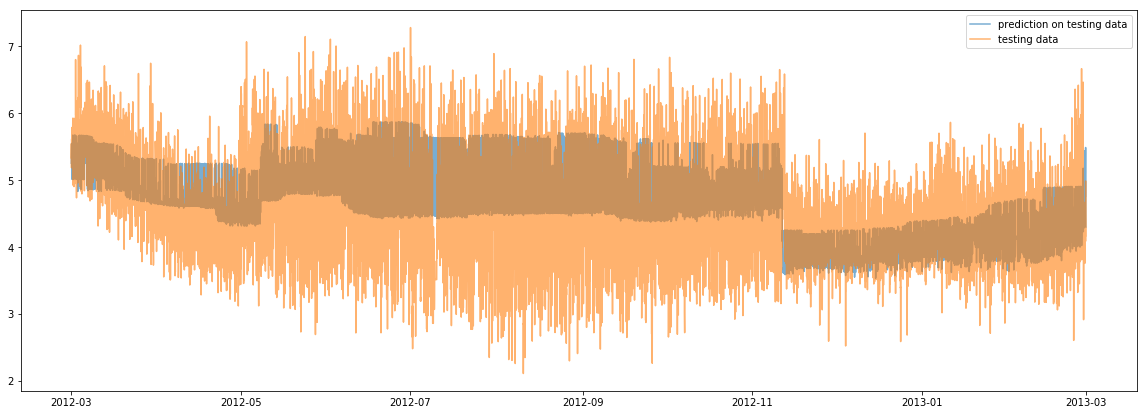

In [71]:
make_plots(combined_rf, combined_train, combined_test)

### So far, it does not work that well ... and the reason is that we are not consiring the thermal intertia
Let's add some features that model the history of what has happened before. For this we will use window based features. There are some time windows size that could make sense:
*   3 hours: half an orbit of Mars Express
*   7 hours: the duration of a Mars Express orbit
*  14 hours: the duration of 2 Mars Express orbits

In [72]:
ewma3_columns = ['ewma3_' + c for c in combined.columns]
ewma7_columns = ['ewma7_' + c for c in combined.columns]
ewma14_columns = ['ewma14_' + c for c in combined.columns]
max3_columns = ['max3_' + c for c in combined.columns]
max7_columns = ['max7_' + c for c in combined.columns]
max14_columns = ['max14_' + c for c in combined.columns]
min3_columns = ['min3_' + c for c in combined.columns]
min7_columns = ['min7_' + c for c in combined.columns]
min14_columns = ['min14_' + c for c in combined.columns]


combinedw = combined.copy()
combinedw[ewma3_columns] = combined.ewm(3).mean()
combinedw[ewma7_columns] = combined.ewm(7).mean()
combinedw[ewma14_columns] = combined.ewm(14).mean()
combinedw[max3_columns] = combined.rolling(3).max().ffill().fillna(0)
combinedw[max7_columns] = combined.rolling(7).max().ffill().fillna(0)
combinedw[max14_columns] = combined.rolling(14).max().ffill().fillna(0)
combinedw[min3_columns] = combined.rolling(3).min().ffill().fillna(0)
combinedw[min7_columns] = combined.rolling(7).min().ffill().fillna(0)
combinedw[min14_columns] = combined.rolling(14).min().ffill().fillna(0)

combinedw.head()

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min,sa,sx,sy,sz,...,min14_PENE,min14_PENS,min14_PPNE,min14_PPNS,min14_SCMN,min14_Trig,min14_UDBE,min14_UDBS,min14_UPBE,min14_UPBS
datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000,0.339355,14.551129,90.339355,104.548871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 01:00:00,2.419331e+08,3.557789e+08,19.557784,522.288980,4.067361,27.380556,6.619310,18.012184,90.500460,90.396437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 02:00:00,2.419273e+08,3.558017e+08,19.550492,522.313961,3.968056,27.361111,30.927137,37.511806,64.618150,86.910793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 03:00:00,2.419216e+08,3.558245e+08,19.543201,522.338941,3.868750,27.341667,1.534306,15.217917,89.967083,105.197917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 04:00:00,2.419158e+08,3.558473e+08,19.535909,522.363922,3.769444,27.322222,0.339672,14.523934,90.339672,104.520492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
combinedw_train, combinedw_test = split_train_test(combinedw)
combinedw_rf = evaluate_rf(combinedw_train, combinedw_test)

MSE train: 0.23071190703790484
MSE test: 0.386138250339035


In [74]:
get_importances(combinedw_rf, combinedw_train.columns)

0.197 sz
0.077 ewma7_evtf_penumbra
0.074 ewma14_solarconstantmars
0.072 ewma3_sz
0.069 ewma14_sunmars_km
0.056 ewma14_RADIO_SCIENCE
0.036 ewma14_evtf_penumbra
0.033 min3_sz
0.031 min3_sx
0.022 max3_sz


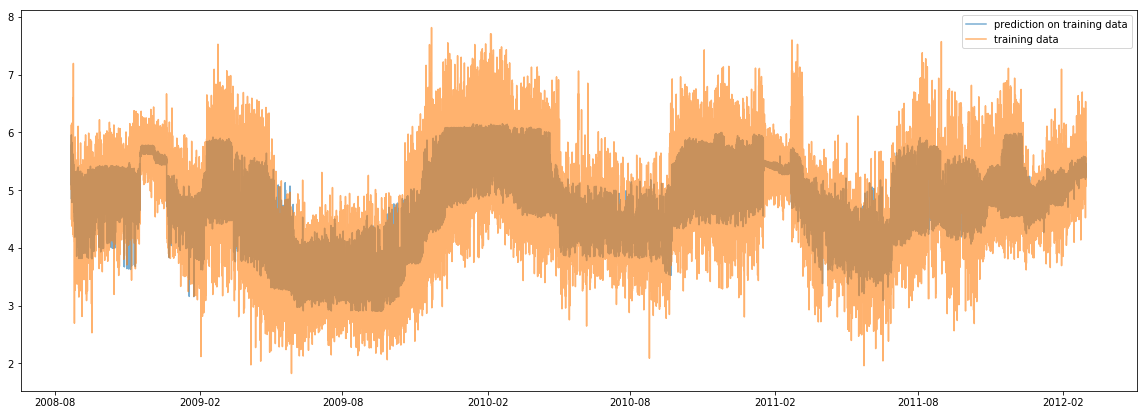

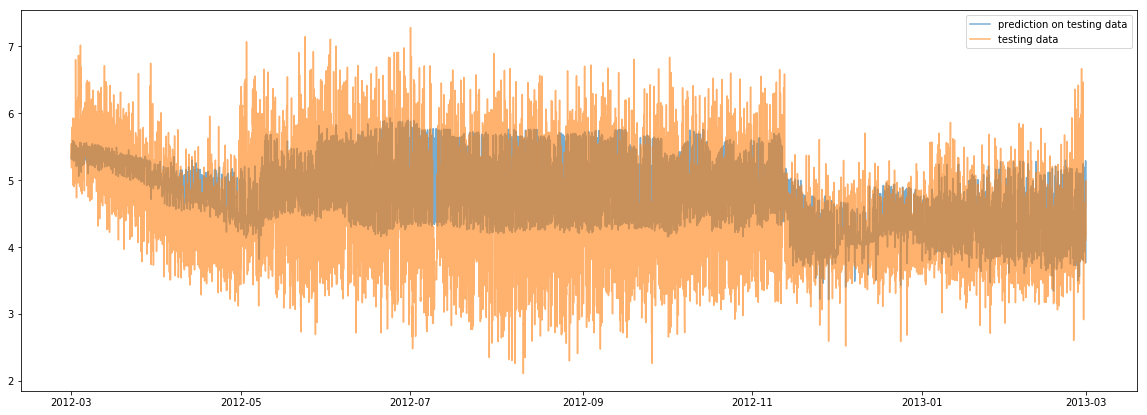

In [75]:
make_plots(combinedw_rf, combinedw_train, combinedw_test)

## Let's create a surrogate model to better understand what's going on

In [76]:
combinedw_tree = DecisionTreeRegressor(max_depth=4, random_state=42)
combinedw_tree.fit(combinedw_train, combinedw_rf.predict(combinedw_train));


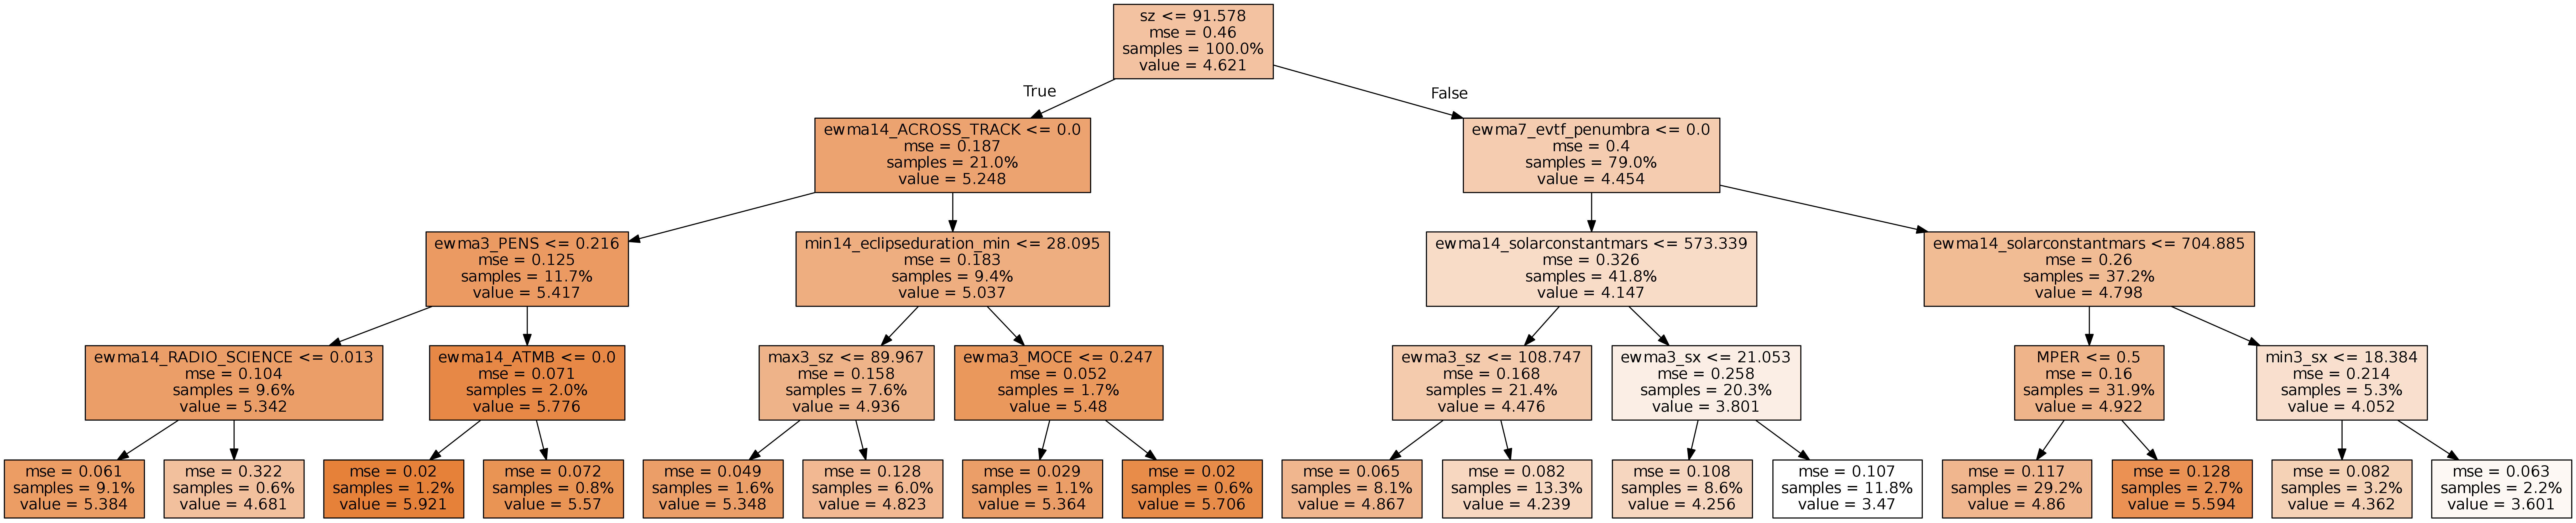

In [77]:
visualize_tree(combinedw_tree, combinedw_train.columns)

In [78]:
evaluate_model(combinedw_tree, combinedw_train, combinedw_test, trained=True)

MSE train: 0.38532107614575123
MSE test: 0.5726266109239138


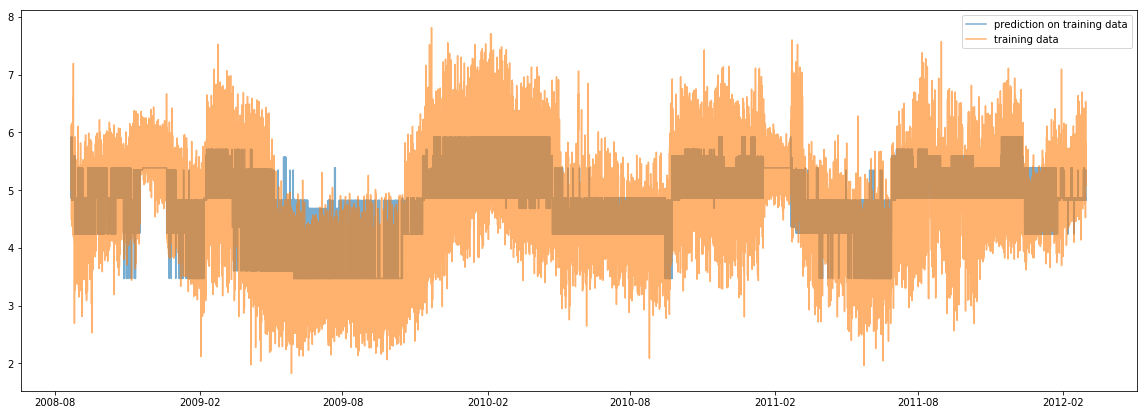

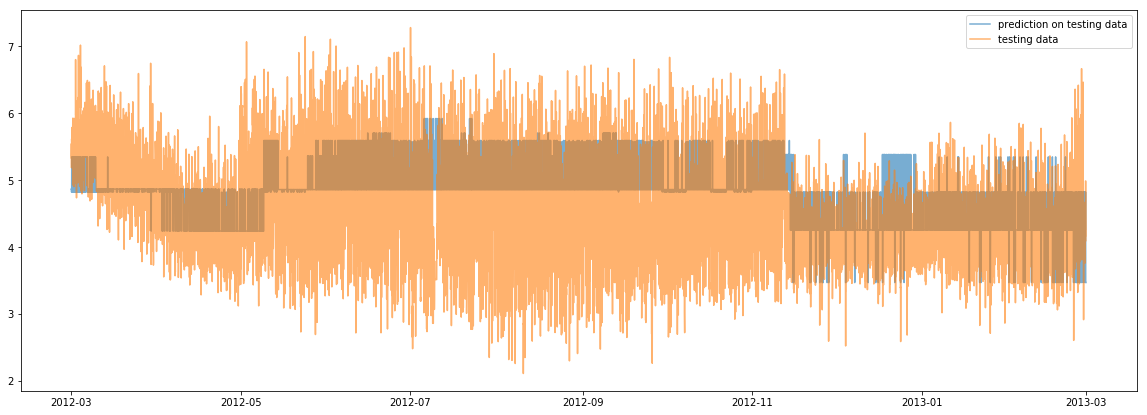

In [79]:
make_plots(combinedw_tree, combinedw_train, combinedw_test)